<a href="https://colab.research.google.com/github/tomcdonald/ml-ai/blob/master/notes/Objective_Functions_and_Supervised_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objective Functions & Supervised Learning

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import time

%matplotlib inline

This week, we move away from probability to further discuss the objective function. We will look at a classification example here, using a Perceptron algorithm.

* Our feature matrices are $\mathbf{x_i}$ for the $i$th instance
* This is a binary classification, so the labels $y_i$ take the value -1 or +1

Our prediction function is given as follows:

\begin{equation}f(\mathbf{x_i})=g(z)=sign(z)=sign(\mathbf{w^Tx_i}+b)=\begin{cases}+1 \quad z>0 \\ -1 \quad z<0 \end{cases} \end{equation}

The decision boundary which determines the class of an instance is given by a hyperplane, where the vector $\mathbf{w}$ is the normal vector to the hyperplane.

The hyperplane is given by $\mathbf{w^Tx}=-b$, although sometimes we use $b=w_0$

Text(0, 0.5, '$x_2$')

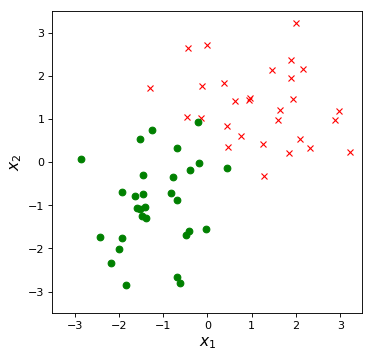

In [3]:
n_data_per_class = 30
np.random.seed(seed=1000001)
x_plus = np.random.normal(loc=1.3, size=(n_data_per_class, 2))
x_minus = np.random.normal(loc=-1.3, size=(n_data_per_class, 2))

# plot data
plt.figure(figsize=(5, 5), dpi=80)
xlim = np.array([-3.5, 3.5])
ylim = xlim
plt.plot(x_plus[:, 0], x_plus[:, 1], 'rx')
plt.plot(x_minus[:, 0], x_minus[:, 1], 'go')
plt.xlim(xlim[0], xlim[1])
plt.ylim(ylim[0], ylim[1]) 
plt.xlabel(r'$x_1$', fontsize=14)
plt.ylabel(r'$x_2$', fontsize=14)

We can draw a hyperplane at the decision boundary to show where a point moves from being classified as -1 to +1. If we expand the prediction function:

\begin{equation} sign(\mathbf{w^Tx_i}+b)=sign(w_1x_{i,1} + w_2x_{i,2}+b) \end{equation}

The equation of the plane defining the decision boundary is given by $w_1x_{i,1} + w_2x_{i,2}+b = 0$ **which can be written as:** 

\begin{equation}w_1x_{i,1} + w_2x_{i,2} = -b\end{equation}

If we select a random data point $\mathbf{x_i}$ from the data, we can check if the current $\mathbf{w}$ and b provide a correct prediction by applying the prediction function, and comparing the output $f(\mathbf{x_i})$ and the true label $y_i$.

In [0]:
# Routine to keep the margins of the drawing box fixed and get the correct margin points for computing the mid points
# later
def margins_plot(x2, xlim, ylim, w, b):
    if (- w[0]/w[1])>0:# cases for a positive slope                
        #xlim = np.flip(xlim, 0)
        #ylim = np.flip(ylim, 0)
        if np.max(x2)>ylim[1] and np.min(x2)<ylim[0]: 
            x_margin_neg = (ylim[1] + (b/w[1]))/(- w[0]/w[1])
            x_margin_pos = (ylim[0] + (b/w[1]))/(- w[0]/w[1])
            y_margin_neg = ylim[1]
            y_margin_pos = ylim[0]
        if np.max(x2)<ylim[1] and np.min(x2)>ylim[0]:
            x_margin_neg = xlim[1]
            x_margin_pos = xlim[0]
            y_margin_neg = (- w[0]/w[1])*xlim[1] - (b/w[1])
            y_margin_pos = (- w[0]/w[1])*xlim[0] - (b/w[1])            
        if np.max(x2)>ylim[1] and np.min(x2)>ylim[0]:
            x_margin_neg = (ylim[1] + (b/w[1]))/(- w[0]/w[1])
            x_margin_pos = xlim[0]
            y_margin_neg = ylim[1]
            y_margin_pos = (- w[0]/w[1])*xlim[0] - (b/w[1])
        if np.max(x2)<ylim[1] and np.min(x2)<ylim[0]:
            x_margin_neg = xlim[1]
            x_margin_pos = (ylim[0] + (b/w[1]))/(- w[0]/w[1])
            y_margin_neg = (- w[0]/w[1])*xlim[1] - (b/w[1]) 
            y_margin_pos =  ylim[0]                  
    else:    
        if np.max(x2)>ylim[1] and np.min(x2)<ylim[0]: 
            x_margin_neg = (ylim[0] + (b/w[1]))/(- w[0]/w[1])
            x_margin_pos = (ylim[1] + (b/w[1]))/(- w[0]/w[1])
            y_margin_neg = ylim[0]
            y_margin_pos = ylim[1]            
        if np.max(x2)<ylim[1] and np.min(x2)>ylim[0]:         
            x_margin_neg = xlim[1]
            x_margin_pos = xlim[0]
            y_margin_neg = (- w[0]/w[1])*xlim[1] - (b/w[1])
            y_margin_pos = (- w[0]/w[1])*xlim[0] - (b/w[1])
        if np.max(x2)>ylim[1] and np.min(x2)>ylim[0]:
            x_margin_neg = xlim[1]
            x_margin_pos = (ylim[1] + (b/w[1]))/(- w[0]/w[1])
            y_margin_neg = (- w[0]/w[1])*xlim[1] - (b/w[1])
            y_margin_pos = ylim[1]   
        if np.max(x2)<ylim[1] and np.min(x2)<ylim[0]:
            x_margin_neg = (ylim[0] + (b/w[1]))/(- w[0]/w[1])
            x_margin_pos = xlim[0]
            y_margin_neg = ylim[0]
            y_margin_pos = (- w[0]/w[1])*xlim[0] - (b/w[1]) 
    return x_margin_neg, x_margin_pos, y_margin_neg, y_margin_pos 

# Routine for plotting
def plot_perceptron(w, b):
    npoints = 100
    xlim = np.array([-3.5, 3.5])
    ylim = xlim
    x1 = np.linspace(xlim[0], xlim[1], npoints)
    x2 = (- w[0]/w[1])*x1 - (b/w[1])
    x_margin_neg, x_margin_pos, y_margin_neg, y_margin_pos = margins_plot(x2, xlim, ylim, w, b)
    x1c = (x_margin_neg + x_margin_pos)/2
    x2c = (y_margin_neg + y_margin_pos)/2
    x2per = (w[1]/w[0])*x1 - (w[1]/w[0])*x1c + x2c
    #plt.axes()
    display.clear_output(wait=True)
    plt.figure(figsize=(5, 5), dpi=80)
    plt.plot(x_plus[:, 0], x_plus[:, 1], 'rx')
    plt.plot(x_minus[:, 0], x_minus[:, 1], 'go')    
    plt.xlabel(r'$x_1$', fontsize=14)
    plt.ylabel(r'$x_2$', fontsize=14)
    plt.plot(x1, x2, 'b')
    #plt.plot(x1, x2per, '--k', color='whitesmoke')
    plt.xlim(xlim[0], xlim[1])
    plt.ylim(ylim[0], ylim[1])    
    plt.arrow(x1c, x2c, w[0], w[1], width=0.03, head_width=0.3, head_length=0.3, fc='k', ec='k') 
    #display.display(plt.gcf())

Now we can initialise the decision boundary:

The sign for the selected value is  1.0


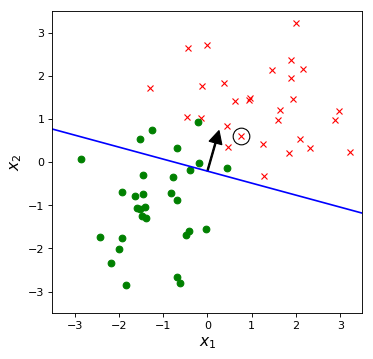

In [5]:
#np.random.seed(seed=1001)
w = 0.5*np.random.randn(2)
b = 0.5*np.random.randn()
plot_perceptron(w, b)
x_selected = x_plus[1]
plt.plot(x_selected[0], x_selected[1], 'o', mfc='none', mec='k', ms=15, lw=5)
print("The sign for the selected value is ", np.sign(np.dot(w, x_selected)+b))

#### Drawing the Decision Boundary

As mentioned previously, the decision boundary is where the prediction function output flips from -1 to +1, representing the location at which the sign function argument is zero. As this dataset is two dimensional, the boundary is a straight line, but in 3D or higher dimensional datasets, the decision boundary is actually a hyperplane, hence why the decision boundary is often known as the *separating hyperplane*.

Plotting the boundary in 2D is relatively simple, as for each value of $x_1$ on the boundary, we simply find the corresponding value of $x_2$ by rearranging the hyperplane formula to give:

\begin{equation}x_2 = -\frac{(b+x_1w_1)}{w_2} \end{equation}

Or alternatively we can choose to specify $x_2$ and calculate $x_1$:

\begin{equation}x_1 = -\frac{(b+x_2w_2)}{w_1} \end{equation}

Which equation we use depends on how the separating hyperplane leaves the plot; if the hyperplane leaves the top and bottom of the plot we'll want to plot a line for all values in the $y$ direction (given by $x_2$), computing $x_1$ for each of these, so that the boundary covers the entire plot. If the line leaves the sides of the plot, then we'll do the opposite, using all values of $x_1$ and calculating $x_2$ for each.

#### Perceptron Algorithm

In [0]:
def update_perceptron(w, b, x_plus, x_minus, learn_rate):
    "Update the perceptron."
    # select a point at random from the data
    choose_plus = np.random.uniform(size=1)>0.5
    updated=False
    if choose_plus:
        # choose a point from the positive data
        index = np.random.randint(x_plus.shape[0])
        x_select = x_plus[index, :]
        if np.dot(w, x_select)+b <= 0.:
            # point is currently incorrectly classified
            w += learn_rate*x_select
            b += learn_rate
            updated=True
    else:
        # choose a point from the negative data
        index = np.random.randint(x_minus.shape[0])
        x_select = x_minus[index, :]
        if np.dot(w, x_select)+b > 0.:
            # point is currently incorrectly classified
            w -= learn_rate*x_select
            b -= learn_rate
            updated=True
    return w, b, x_select, updated

We want to find the parameters $\mathbf{w}$ and b which allow a correct prediction for a datapoint $\mathbf{x_i}$. This can be achieved by writing an algorithm whereby, if the vector $\mathbf{x_i}$ is classified correctly, we don't change the parameters, but if the vector is incorrectly classified, we change those parameters by adding a correction term, with the hope that this will improve the model.

Specifically:

* If $\mathbf{x_i}$ is incorrectly classified as negative when it's actually positive, we add $\eta\mathbf{x_i}$ to $\mathbf{w}$ and $\eta$ to b.

* If $\mathbf{x_i}$ is incorrectly classified as positive when it's actually negative, we subtract $\eta\mathbf{x_i}$ from $\mathbf{w}$ and $\eta$ from b.

* $\eta$ is called the learning rate; increasing this will result in larger correction 'jumps'.